### Still plugging away... 

It's time to get to (prepping for) audio

In [1]:
# Just your usual setup

import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fdls
import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [2]:
pi = np.pi
tau = np.pi * 2

# It's optimal if this is a power of 2.  
# For CPU use 16K appears best, but it looks like a lot of samples need to be cut for audio
blocklenk = 32
blocklen = (blocklenk * 1024)
# slice of FFT used for audio frequency reduction (needs to be 1/16'th blocklen for now)
aslice = slice(512, 1536)

# hilbert_filter_terms has a direct impact on filter delays
#hilbert_filter_terms = 128
# typically the most delay added is 128 (NTSC chroma bandpass) but best to be safe for now
#blockcut = hilbert_filter_terms + 192

# need to figure this out - audio's filters currently have much greater delay...
blockcut = 2048

In [3]:
# charting/graphing code carried over from earlier development efforts
# (will probably be moved back into a ldutils2 package)

def dbify(y):
    db = 20 * np.log10(np.abs(y))
    return db - np.max(db)

# TODO: merge with below
def doplot(B, A, freq = 40, extra = None, whole = False):
    w, h = sps.freqz(B, A, whole = whole)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    db = 20 * np.log10(abs(h))
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= 3) and (db[i - 1] < 3):
            print(">3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] <= -10) and (db[i - 1] > -10):
            print("<-10db crossing at ", w[i] * (freq/pi) / 2.0) 

    ax1 = fig.add_subplot(111)

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')
    
    #return 20 * np.log10(abs(h))
    
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')

    if extra is not None:
        plt.plot(*extra)
    
    plt.grid()
    plt.axis('tight')
    plt.show()
    
    return None

def plotfilt(filterset, key, power = 1.0, extra = None):
    # take the first half of the FFT multiplier
    h = filterset[key] ** power
    h = h[0:len(h)//2]
    
    freq = filterset['freq'] / 2
    w = np.arange(0, freq, freq / len(h))

    db = 20 * np.log10(abs(h))
    above_m3 = None
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i]) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i])
            above_m3 = i
        if (db[i] < -3) and (db[i - 1] >= -3):
            if above_m3 is not None:
                peak_index = np.argmax(db[above_m3:i]) + above_m3
                print("peak at ", w[peak_index], db[peak_index])
            print("<-3db crossing at ", w[i]) 
        if (db[i] >= 3) and (db[i - 1] < 3):
            print(">3db crossing at ", w[i]) 
    
    fig, ax1 = plt.subplots(1, 1, sharex=True)
    ax1.set_title('Digital filter frequency response')

    ax1.plot(w, db, 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency [rad/sample]')
    
    #return 20 * np.log10(abs(h))
    
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')

    if extra is not None:
        plt.plot(*extra)
    
    plt.grid()
    plt.axis('tight')
    plt.show()
    
    return None

# Draws a uint16 image, downscaled to uint8
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [4]:
# System default specs for NTSC and PAL.

# IEC 60857 9.2.2: the range from -40 to 100 IRE is 1.7mhz, with 0 at 8.1mhz.  Maximum is 110IRE.
NTSC_hz_ire = 1700000 / 140.0

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,

    'fsc_mhz': (315.0 / 88.0),
    'line_period': 63.5, # in usecs

    # video frequencies 
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match legacy ld-decode scaling
    'ire_min': -60,
    'ire_max': 140,

    # tunable parameters.  These work well with DD 2_2 + eliptical filter, which is a bit more
    # picky about audio RF filtering.
    
    # (note:  i don't know how to handle these values perfectly yet!)
    'deemp': (120*.7, 320*.7), # On some captures this is as low as .55.

    # The audio notch filters are important with DD v3.0+ boards
    'audio_filtwidth': 350000,
    'audio_filtorder': 2,

    # This BPF similar but not *quite* identical to what Pioneer did
    'vbpf': (3500000, 13200000),
    'vbpf_order': 3,
    
    # This can easily be pushed up to 4.5mhz or even a bit higher. 
    # A sharp 4.8-5.0 is probably the maximum before the audio carriers bleed into 0IRE.
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 5 # butterworth filter order
    
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'line_period': 64, # in usecs
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    
    # The PAL spec does not use IRE but rather voltage.
    'videorf_0ire': 7100000, # the sync signal peaks about here at full saturation
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    


In [5]:
#https://stackoverflow.com/questions/20924085/python-conversion-between-coordinates
polar2z = lambda r,θ: r * np.exp( 1j * θ )
deg2rad = lambda θ: θ * (np.pi / 180)

In [6]:
# Load up default parameters

params = {'freq': 40, 'blocklen': blocklen}

for p in [SysParams_NTSC]:
    for k in p.keys():
        #print(k, p[k])
        params[k] = p[k]
        
params['MTF'] = sps.zpk2tf(.1, -.5, 1.65)
params['MTF'] = sps.zpk2tf([], [polar2z(.7,np.pi*12.5/20), polar2z(.7,np.pi*27.5/20)], 1.11)

In [7]:
# (mostly the) old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140

hz_ire_scale = 1700000 / 140

# NTSC
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [8]:
hz0ire = params['videorf_0ire']

In [9]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

# crude zero-crossing calculator.

def iretohz(ire):
    return hz0ire + (hz_ire_scale * ire)

def hztoire(hz):
    return (hz - hz0ire) / hz_ire_scale

m20ire = iretohz(-20)

def calczc(data, _start_offset, target, _count=10):
    start_offset = int(_start_offset)
    count = int(_count + 1)
    if data[start_offset] < target:
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
    
    if len(locs) == 0:
        return None
        
    x = start_offset + locs[0]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [10]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html

# hilbert_filter_terms has a direct impact on filter offsets.  Emperical testing
# determined that 128 was a good value here.
hilbert_filter_terms = 128
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*hilbert_filter_terms+[0]*hilbert_filter_terms)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do a good chunk of real demoduation work
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

# This converts a regular B, A filter to an FFT of our selected block length
def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

Decoding notes:

- My RF decoder is based off frequency-domain transforms.  This allows multiple filters to be applied in one operation, and multiple different filters can also be applied, which will come into play when working on audio

In [11]:
# This filter (attempts to) compensate for phase distortion from the 2-pole elliptical filter
# on the DD 3.0 board.  It still needs some development work, but a little phase adjustment
# goes a long way to improve colors
def calculate_dd_filter(params):
    filterdata = pd.read_csv('dd30phase.csv').iloc[:]
    # add an ending to try to keep freq response closer to even
    filterdata.loc[65] = [20000000, 144]

    ffreq = (filterdata.hz / (params['freq_hz'] / 2)) * np.pi

    fphase = (filterdata.phase) * (np.pi / 180)
    flevela = np.ones_like(fphase)

    fphase[58:] += (np.pi* 2)

    cut = 0
    cutend = len(ffreq)-0
    _level = 1
    _shift = -.02
    dimb = 1
    dima = 3
    [fb, fa] = fdls.FDLS(dimb, dima, ffreq[cut:cutend], np.ones_like(ffreq[cut:cutend]), fphase[cut:cutend]*_level, shift=_shift)

    return fb, fa



In [12]:
def audio_fdslice(SP, freqdomain):
    return np.concatenate([freqdomain[SP['audio_fdslice_lo']], freqdomain[SP['audio_fdslice_hi']]])

# This prepares the needed transforms to do the actual video decoding
# (and first bit of audio to go along with it)
def prepare_video_filters(params):
    SP = copy.deepcopy(params)
    blocklen = params['blocklen']
    
    SP['hilbert_filter_terms'] = hilbert_filter_terms
    
    # build up a couple more constants
    SP['freq_hz'] = SP['freq'] * 1000000.0
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000.0)
    
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2
    freq_half = SP['freq'] / 2

    # RF BPF filter, which will get the audio notch filters added if needed
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'), blocklen)
    
    # If there is analog audio, it must be filtered well especially with DD >=3.0-beta RF captures
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'), blocklen)
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'), blocklen)
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    #tmp = filtfft([fb, fa], blocklen)
    #SP['FRFVideo'] *= tmp
    
    #SP['FRFVideo'] *= exp
    
    SP['Fhilbert'] = np.fft.fft(hilbert_filter, blocklen)
    
    SP['Fdd'] = filtfft(calculate_dd_filter(SP), blocklen)
    
    # This MTF filter needs A LOT of work!
    #[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.65)
    SP['Fmtf'] = filtfft(SP['MTF'], blocklen)
    
    # The above is multiplied with a Hilbert transform to get (partway) to demodulation
    
    # The 4.2-4.6mhz (NTSC)/5.x mhz (PAL) demodulated lowpass filter
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low'), blocklen) # standard 4.Xmhz

    # The deemphasis filter.  This math is probably still quite wrong, but with the right values it works
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10), -SP['deemp'][0]*(10**-10), SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half), blocklen)

    # The direct opposite of the above, used in test signal generation
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][0]*(10**-10)/2.0, -SP['deemp'][1]*(10**-10)/2.0, SP['deemp'][1] / SP['deemp'][0])
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][0]*(10**-10), -SP['deemp'][1]*(10**-10), SP['deemp'][1] / SP['deemp'][0])
    SP['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half), blocklen)
    
    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp'] 
    
    # additional filters:  0.5mhz and color burst
    SP['F0_5'] = filtfft(sps.butter(4, 0.5/freq_half, 'low'), blocklen) 
    SP['FVideo05'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['F0_5']

    if SP['system_name'] == 'NTSC':
        SP['Fburst_len'] = int(np.ceil((18 * freq_half / SP['fsc_mhz']) / 2) * 2)
        SP['Fburst_delay'] = SP['Fburst_len'] // 2
#        print(SP['Fburst_len'])
        bf = sps.firwin(SP['Fburst_len'] + 1, [(SP['fsc_mhz'] * .975)/freq_half, (SP['fsc_mhz'] * 1.025)/freq_half], pass_zero=False)
        SP['Fburst'] = filtfft((bf, [1.0]), blocklen)
        SP['imglen'] = (int)((SP['freq_hz'] / 59.976) * 1.25)
    else:
        # For PAL this is a 3.75mhz filter
        SP['Fburst'] = filtfft(sps.butter(1, [3.7/freq_half, 3.8/freq_half], btype='bandpass')) 
        SP['imglen'] = (int)((SP['freq_hz'] / 50) * 1.25)
        
    SP['FVideoBurst'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['Fburst']
    
    # emperical work determined that a single-pole low frequency filter effectively 
    # detects the end of a (regular) sync pulse when binary level detection is used. TODO: test with PAL
    f = sps.butter(1, 0.05/(params['freq'] / 2.0), btype='low')
    SP['FPsync'] = filtfft(f, blocklen)

    # first stage audio filters
    
    arf_div = 32 # this is good for 40mhz - 16 should be ideal for 28mhz
    afft_halfwidth = (blocklen / arf_div) / 2
    arf_freq = SP['freq_hz'] / (arf_div / 2)
    SP['freq_arf'] = arf_freq
    
    SP['audio_cfreq'] = (SP['audio_rfreq'] + SP['audio_lfreq']) // 2
    afft_center = int((SP['audio_cfreq'] / SP['freq_hz']) * (blocklen))

    # beginning and end symmetrical frequency domain slices.  combine to make a cut-down sampling
    afft_start = int(afft_center-afft_halfwidth)
    afft_end = int(afft_center+afft_halfwidth)

    # slice areas for reduced FFT audio filters
    SP['audio_fdslice_lo'] = slice(afft_start, afft_end)
    SP['audio_fdslice_hi'] = slice(blocklen-afft_end, blocklen-afft_start)

    apass = 150000
    afilt_len = 800 # good for 150khz apass

    afilt_left = filtfft([sps.firwin(afilt_len, [(SP['audio_lfreq']-apass)/freq_hz_half, (SP['audio_lfreq']+apass)/freq_hz_half], pass_zero=False), 1.0])
    SP['audio_lfilt'] = audio_fdslice(SP, afilt_left * SP['Fhilbert']) 
    afilt_right = filtfft([sps.firwin(afilt_len, [(SP['audio_rfreq']-apass)/freq_hz_half, (SP['audio_rfreq']+apass)/freq_hz_half], pass_zero=False), 1.0])
    SP['audio_rfilt'] = audio_fdslice(SP, afilt_right * SP['Fhilbert'])
    
    return SP

In [13]:
# The actual video demodulation code

def hilberttohz(hilbert, freq = 40000000):
    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    # With extremely bad data, the unwrapped angles can jump.
    while np.min(tdangles2) < 0:
        tdangles2[tdangles2 < 0] += tau
    while np.max(tdangles2) > tau:
        tdangles2[tdangles2 > tau] -= tau
    return (tdangles2 * (freq / tau))

def dodemod(paramsc, data, mtf_level = 0, dd_level = 1.0, cutarf = False):
    indata_fft = np.fft.fft(data)
    indata_fft_filt = indata_fft * paramsc['FRFVideo']

    if mtf_level != 0:
        indata_fft_filt *= paramsc['Fmtf'] ** mtf_level

    if dd_level != 0:
        indata_fft_filt *= paramsc['Fdd'] ** dd_level

    hilbert = np.fft.ifft(indata_fft_filt * paramsc['Fhilbert'])
    demod = hilberttohz(hilbert, paramsc['freq_hz'])

    demod_fft = np.fft.fft(demod)
    
    out_video = np.fft.ifft(demod_fft * paramsc['FVideo']).real
    out_video05 = np.fft.ifft(demod_fft * paramsc['FVideo05']).real
    out_videoburst = np.fft.ifft(demod_fft * paramsc['FVideoBurst']).real
    
    # NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks
    output_sync = (out_video > (params['videorf_0ire'] + (params['hz_ire'] * -55))) & (out_video < (params['videorf_0ire'] + (params['hz_ire'] * -25)))
    # Perform FFT convolution of above filter
    output_syncf = np.fft.ifft(np.fft.fft(output_sync) * paramsc['FPsync']).real
    
    rv_video = np.rec.array([out_video, out_video05, output_syncf, out_videoburst], names=['demod', 'demod_05', 'demod_sync', 'demod_burst'])

    if params['analog_audio'] == False:
        return rv_video, None

    # Audio section
    hilbert = np.fft.ifft(audio_fdslice(paramsc, indata_fft) * paramsc['audio_lfilt'])
    audio_left = hilberttohz(hilbert, paramsc['freq_arf'])

    hilbert = np.fft.ifft(audio_fdslice(paramsc, indata_fft) * paramsc['audio_rfilt'])
    audio_right = hilberttohz(hilbert, paramsc['freq_arf'])

    rv_audio = np.rec.array([audio_left, audio_right], names=['audio_left', 'audio_right'])
    
    return rv_video, rv_audio

In [14]:
def lineplot(output, param):
    plt.plot(np.clip(output, 7400000, 9850000))
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [15]:
# note: currently returns PSNR assuming IRE==100
def calcsnr(a):
    #stdire = np.std(a) / NTSC_hz_ire
    #return(20 * np.log10(100 / stdire))
    
    signal = hztoire(np.mean(a))
    noise = np.std(a) / hz_ire_scale
    #print(signal, noise)
    return 20 * np.log10(70 / noise)


In [16]:
# Scaler code in Python is horribly slow - numpy is a bit less so

# Thankfully for bit unpacking there are numpy routines to operate on bit arrays...
def load_packed_data(infile, sample, readlen = blocklen):
    start = (sample // 3) * 4
    offset = sample % 3
    start, offset

    infile.seek(start)

    # we need another word in case offset != 0
    needed = int(np.ceil(readlen * 3 / 4) * 4) + 4

    inbuf = infile.read(needed)
    indata = np.fromstring(inbuf, 'uint32', len(inbuf) // 4)

    unpacked = np.zeros(len(indata) * 3, dtype=np.int16)

    # By using strides the unpacked data can be loaded with no additional copies
    np.bitwise_and(indata, 0x3ff, out = unpacked[0::3])
    # hold the shifted bits in it's own array to avoid an allocation
    tmp = np.right_shift(indata, 10)
    np.bitwise_and(tmp, 0x3ff, out = unpacked[1::3])
    np.right_shift(indata, 20, out = tmp)
    np.bitwise_and(tmp, 0x3ff, out = unpacked[2::3])

    return unpacked[offset:offset + blocklen]

In [17]:
def loaddata(infile, sample):

    # packed data is a bit more complicated
    if sampletype == 3:
        return load_packed_data(infile, sample)

    infile.seek(sample * sampletype, 0)
    inbuf = infile.read(blocklen * sampletype)

    if sampletype == 2:
        indata = np.fromstring(inbuf, 'int16', len(inbuf) // 2)
    else:
        indata = np.fromstring(inbuf, 'uint8', len(inbuf))
    
    return indata


In [18]:
def demod(infile, _start, _end, filterset, mtf_level = 0.0, dd_level = 1.0):
    infile_len = infile.seek(0, 2)
    
    if _end > infile_len:
        end = infile_len
    else:
        end = int(_end)
    
    if (_start > blockcut):
        start = int(_start - blockcut)
    else:
        start = 0 # should this be an error?  prolly.

    #print(start, end, (end - start))
    
    # set a placeholder
    output = None
    output_audio = None
        
    for i in range(start, end, blocklen - blockcut):
        #print(i, start, end)
        indata = loaddata(infile, i)
        if indata is None:
            break
        
        tmp_video, tmp_audio = dodemod(filterset, indata, mtf_level, dd_level)
        
        # if the output hasn't been created yet, do it now using the 
        # data types returned by dodemod (should be faster than multiple
        # allocations...)
        if output is None:
            output = np.zeros(end - start + 1, dtype=tmp_video.dtype)
        
        if i - start + (blocklen - blockcut) > len(output):
            copylen = len(output) - (i - start)
        else:
            copylen = blocklen - blockcut
            
        output_slice = slice(i - start, i - start + copylen)
        tmp_slice = slice(blockcut, blockcut + copylen)
            
        output[output_slice] = tmp_video[tmp_slice]

        # repeat the above - but for audio
        if tmp_audio is not None:
            audio_downscale = tmp_video.shape[0] // tmp_audio.shape[0]
            
            if output_audio is None:
                output_audio = np.zeros(((end - start) // audio_downscale) + 1, dtype=tmp_audio.dtype)
            
            output_slice = slice((i - start) // audio_downscale, (i - start + copylen) // audio_downscale)
            tmp_slice = slice(blockcut // audio_downscale, (blockcut + copylen) // audio_downscale)
            
            output_audio[output_slice] = tmp_audio[tmp_slice]

    return output, output_audio
    

In [19]:
# since the filter parameters can cause many different effects, it is essential 
# to determine filter delays etc automatically

In [20]:
def genwave(rate, freq, initialphase = 0):
    out = np.zeros(len(rate), dtype=np.double)
    
    angle = initialphase
    
    for i in range(0, len(rate)):
        angle += np.pi * (rate[i] / freq)
        if angle > np.pi:
            angle -= tau
        
        out[i] = np.sin(angle)
        
    return out

In [21]:
# generate a fake signal and (try to ) decode it correctly :)
def calc_demodgaps(filterset):
    # generate a fake signal and (try to ) decode it correctly :)
    #def calc_demodgaps(filterset):
    fakeoutput = np.zeros(filterset['blocklen'], dtype=np.double)

    # set base level to black
    fakeoutput[:] = 8100000

    # sync
    fakeoutput[1000:1300] = 7600000

    # color burst

    burstlen = int(18 * ((filterset['freq'] / 2) / (315/88)) )
    rate = np.full(burstlen, (315/88.0), dtype=np.double)
    fakeoutput[1500:1500+burstlen] = 8100000 + (genwave(rate, filterset['freq'] / 2) * 250000)

    burstlen = int(64 * ((filterset['freq'] / 2) / (315/88)) )
    rate = np.full(burstlen, (315/88.0), dtype=np.double)
    fakeoutput[0:0+burstlen] = 8100000 + (genwave(rate, filterset['freq'] / 2) * 250000)

    # white
    fakeoutput[2000:3000] = 9100000

    #[tf_b, tf_a] = sps.zpk2tf(-filterset['deemp'][1]*(10**-10)/2.0, -filterset['deemp'][0]*(10**-10)/2.0, filterset['deemp'][0] / filterset['deemp'][1])
    #filterset['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/(filterset['freq_hz'] / 2.0)))

    tmp = np.fft.fft(fakeoutput)
    tmp2 = tmp * filterset['Fvideo_lpf']
    tmp3 = tmp2 * filterset['Femp']

    fakeoutput_lpf = np.fft.ifft(tmp2).real
    fakeoutput_emp = np.fft.ifft(tmp3).real

    fakesignal = genwave(fakeoutput_emp, filterset['freq_hz'] / 2)
    fakedecode, fakedecode_audio = dodemod(filterset, fakesignal)

    # Determine filter lag (mostly the length of the hilbert filter)
    filterset['dgap'] = calczc(fakedecode['demod'], 950, iretohz(-20), 256 + hilbert_filter_terms) - calczc(fakeoutput_emp, 950, iretohz(-20), 500)

    # Now use above to calc the lag of the 0.5mhz filter
    dgap05_1 = calczc(fakedecode['demod_05'], 900 + filterset['dgap'], iretohz(-20), 500) - calczc(fakedecode['demod'], 900 + filterset['dgap'], iretohz(-20), 500)
    dgap05_2 = calczc(fakedecode['demod_05'], 1250 + filterset['dgap'], iretohz(-20), 500) - calczc(fakedecode['demod'], 1250 + filterset['dgap'], iretohz(-20), 500)
    filterset['dgap_05'] = (dgap05_1 + dgap05_2) / 2

    fdburst_adj = fakedecode['demod_burst'][filterset['Fburst_delay']:]

    # find the last bottom of the emulated burst, then it's zero crossing
    c17_5 = 1500 + np.argmax(-fdburst_adj[1500:])
    c16_5 = c17_5 - ((filterset['freq'] / 2) / (315/88)) 

    c17 = calczc(fdburst_adj, int(c16_5), 0)
    c17_orig = 1500 + 17 * ((filterset['freq'] / 2) / (315/88)) 

    # find the *phase* difference of the peak (which is actually in the middle of the burst)
    # and the demodulated wave

    c17_demod = calczc(fakedecode['demod'], int(c16_5), 8100000)
    filterset['dgap_burst'] = (c17 - c17_demod)

    # not what we actually want ;)
    #filterset['dgap_burst'] = (c17 - c17_orig) - filterset['dgap']

    return fakeoutput, fakedecode

In [22]:
def pxtousec(px, freq = 40000000):
    return (px / freq) * 1000000

def usectopx(usec, freq = 40000000):
    return freq * usec / 1000000

Below this is the less developed code to deal with NTSC framing and syncs.

A plot of output_syncf here shows a nice pattern overall:

- Vsyncs reach 1.0 (and the mininum in those areas is ~0.23)
- regular hsyncs come in about 0.77 (the glitches are where the LD player "rewinds" for still frames)
- equalization pulses come in about 0.5

In [23]:
def findfirstframe(infile, start = 0):

    readlen = int(128 * filterset['line_px'])

    loc = start
    while (loc - start) < filterset['freq_hz']:
#        print(loc)
        data, data_audio = demod(infile, loc, loc + readlen, filterset)
        
        if np.max(data['demod_sync']) > .9:
            if (np.argmax(data['demod_sync']) / filterset['line_px']) > 100:
                loc += np.argmax(data['demod_sync']) - int(16 * filterset['line_px'])
                continue
            if (np.argmax(data['demod_sync']) / filterset['line_px']) < 16:
                loc += np.argmax(data['demod_sync']) - int(16 * filterset['line_px'])
                continue
        else:
            loc += int(120 * filterset['line_px'])
            continue
                
        #print(loc, np.max(data['demod_sync']), np.mean(data['demod_sync']))
        syncloc, firstfield, nextline = findsync(data['demod_sync'])
        
        #print(loc, loc + syncloc, firstfield, np.max(data['demod_sync']), np.mean(data['demod_sync']))
        
        if syncloc and firstfield:
            loc += int(240 * filterset['line_px'])
            #return loc + nextline, data
        elif syncloc and not firstfield:
            return loc + nextline, data
        else:
            loc += int(120 * filterset['line_px'])
    
    return None

In [24]:
# note:  this VBI decoder works with unscaled lines.
def decodephillipscode(data, linestart):
    #print(linestart)
    curzc = calczc(data, int(linestart + usectopx(2)), iretohz(50), int(usectopx(12)))

    zc = []
    while curzc is not None:
        zc.append((curzc, data[int(curzc - usectopx(0.5))] < iretohz(50)))
        curzc = calczc(data, curzc+usectopx(1.9), iretohz(50), int(usectopx(0.2)))

    usecgap = pxtousec(np.diff([z[0] for z in zc]))
    valid = len(zc) == 24 and np.min(usecgap) > 1.85 and np.max(usecgap) < 2.15

    if valid:
        bitset = [z[1] for z in zc]
        linecode = []
        for b in range(0, 24, 4):
            linecode.append((np.packbits(bitset[b:b+4]) >> 4)[0])
        #print(bitset)
        #print(linecode)
        return linecode
    else:
        return None
    
def processphillipscode(data, lines):
    rv = {'codes': []}
#    codes = []
    for l in [16, 17, 18, 279, 280, 281]:
        lc = decodephillipscode(data, lines[l])
        if lc is not None:
            rv['codes'].append((l, lc))
            if lc[0] == 15: # frame code
                if lc[2] == 13: # CLV
                    print('CLV')
                    rv['frame'] = -1
                else: # CAV
                    frame = (lc[1] & 7) * 10000
                    frame += (lc[2] * 1000)
                    frame += (lc[3] * 100)
                    frame += (lc[4] * 10)
                    frame += lc[5] 
                    print('CAV frame #', frame)
                    rv['frame'] = frame
                    
    return rv

In [25]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]

In [26]:
def inpicture(linenum):
    if linenum is None:
        return False
    
    return inrange(linenum, 10, 263.4) or inrange(linenum, 273, 525)

#linelocs, end = findsync(frame, 0)

# this needs *a lot* of cleaning up
def cburstalign(frame, lineinfo, badburst, shift33 = -((33.0 / 360.0) * np.pi)):
    lineinfo_tmpa = lineinfo.copy()
    offset = 0
    
    output = frame['demod']
    output_burst = frame['demod_burst']
    
    peak = []
    cuts = []
    for l in range(1, 525):
        if badburst[l]:
            #lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offset - filterset['dgap_burst']
            continue
        
        tmp = lineinfo_tmpa[l] + filterset['Fburst_delay']
        cut = output_burst[int(tmp):int(tmp+usectopx(3.5))].copy()
        cut -= cut.mean()
        
        peak.append(np.argmax(np.abs(cut)))
        
    peak = np.array(peak)
    peakmean = peak.mean()
    
    zc = []
    linelens = []
    for l in range(1, 525):
        if badburst[l]:
            continue

        tmp = lineinfo_tmpa[l] + filterset['Fburst_delay']
        cut = output_burst[int(tmp):int(tmp+usectopx(3.5))].copy()
        cut -= cut.mean()

        #zc.append(calczc(cut, np.floor(peakmean), 0, 5))
        linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
        try:
            zc.append(calczc(cut, np.floor(peakmean), 0, 5) * (outwidth / linelen))
            linelens.append(lineinfo_tmpa[l + 1] - lineinfo_tmpa[l])
        except:
            None
        
    print("zcmean ", np.mean(zc), np.mean(zc) * (outwidth / np.mean(linelens)))
        
    offsets = np.zeros(len(lineinfo_tmpa), dtype=np.double)
    for l in range(1, 525):
        if badburst[l]:
            lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offset - filterset['dgap_burst']
            continue

        linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
        tmp = lineinfo_tmpa[l] + filterset['Fburst_delay']
        cut = output_burst[int(tmp):int(tmp+usectopx(3.5))].copy()
        cut -= cut.mean()

        try:
            adjpeak = (calczc(cut, np.argmax(np.abs(cut)), 0) + filterset['dgap_burst']) * (outwidth / linelen)
        except:
            #print('bad burst', l, lineinfo[l], lineinfo2[l], tmp)
            badburst[l] = True
            lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offsets[l - 1] - filterset['dgap_burst']
            continue

        # find the nearest odd # for the peak crossover.
        target = (np.round((adjpeak - 1) / 2) * 2) + 1
        offsets[l] = (adjpeak - target)

        #print('fs ', l, np.argmax(cut), adjpeak, target,  offsets[l], lineinfo2[l], lineinfo_tmpa[l], lineinfo_tmpa[l] - lineinfo_tmpa[l - 1])
            
    if np.mean(np.abs(offsets)) > .8:
        print("WARNING: offsets too high")
            
    # outlier repair.  TODO:  handle more than one outlier line in a row?
    for l in range(2, 524):
        if badburst[l]:
            continue

        offset = offsets[l]
        if (np.abs(offsets[l] - offsets[l - 1]) > 1.2) and (np.abs(offsets[l] - offsets[l + 1]) > 1.2):
            print("outlier repair ", l, offsets[l - 1:l + 2])
            if offsets[l] > 0:
                offsets[l] -= outfsc // 2
            else:
                offsets[l] += outfsc // 2
            
    lineinfo_cphaseadj = lineinfo_tmpa.copy()
    for l in range(1, 525):
        linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
        lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + (offsets[l]  * (linelen / outwidth)) #- filterset['dgap_burst']    
        lineinfo_cphaseadj[l] =  lineinfo_tmpa[l] + (shift33 * (linelen / outwidth)) #- filterset['dgap_burst']    

    return lineinfo_tmpa, lineinfo_cphaseadj, offsets

badburst = np.zeros(526)
#linelocs2, linelocs2_phaseadj, offsets = cburstalign(frame, linelocs, badburst)

In [27]:
# this still needs to be simplified... 

# mingap is set to 12 to hopefully ensure that there's enough audio decoding to allow
# the long-lag audio filters to work...
def findsync_getpulses(frame, start, line_px = 2540, lines = 525, mingap = 12):
    curloc = start

    # need to leave some padding for backward searches
    if curloc < 512:
        curloc = 512
        
    ilinepx = int(line_px)
    
    output = frame['demod']
    output_sync = frame['demod_sync']

    lastline = start
    linenum = None
    lineinfo = {}
    
    sstart = 0
    send = int(line_px)
    
    # Check every half-line for equalization pulses
    
    while linenum is None or (linenum <= 526 and ((curloc - lastline) < (lines * line_px))):
        offset = np.argmax(output_sync[curloc + sstart:curloc + send])
        lineloc = curloc + sstart + offset
        
        #lineloc = int(np.round(calczc(frame['demod'], lineloc-300, iretohz(-20), 500)))

        synclevel = output_sync[lineloc]

        # the adjustment factor is set per line type - calibrated against an acutal disk
        adjustment = 0
        if inrange(synclevel, 0.65, 0.8) or (inpicture(linenum) and inrange(synclevel, 0.3, 0.85)): # regular line
            # find the zero crossing of the non-filtered demod signal... or interpolate if this is wrong
            try:
                lineloc = int(np.round(calczc(output, lineloc - 10, iretohz(-20), 30)))
            except:
                lineloc = lineinfo[linenum - 1]  + (lineinfo[linenum - 1] - lineinfo[linenum - 2])
                #None

            sstart = int(line_px * .45)
            send = int(line_px * .55)
            
            lastline = lineloc
            # If we're in the middle of a frame, don't scan mid-lines
            if linenum is not None and inpicture(linenum):
                curloc = lineloc + int(line_px * .5)
            else:
                curloc = lineloc
                
        elif inrange(synclevel, 0.4, 0.65): # equalization pulse - before and after vsync
            if not inrange(lineloc - lastline, line_px * .95, line_px * 1.05) and linenum is None:
                return None, curloc + (ilinepx * (262 - mingap))
            elif linenum is None:
                # ensure there's enough space before the burst to get audio filters going
                if lineloc < (mingap * line_px):
                    return None, curloc + (ilinepx * (525 - mingap))
                linenum = 1
            # adjust to match observed color burst timing
            adjustment = int(usectopx(2.4))
            curloc = lineloc
        elif inrange(synclevel, 0.8, 1.01): # vsync
            # VSYNC pulse is active low - I found that using the derivative of the sync LPF works nicely
            demod_sync_diff = np.diff(frame['demod_sync'][int(lineloc)-500:int(lineloc)])
            lineloc = lineloc - 500 + np.argmax(demod_sync_diff)

            # The color burst - if it happens - is about 4.6usec after vsync starts
            adjustment = int(usectopx(4.65))
            curloc += int(line_px * .5)
        else: # probably middle of regular line
            curloc += int(line_px * .5)
            
        if linenum is not None:
            # save integers if not a half-line
            if np.abs(linenum - np.int(linenum)) > .1:
                lineinfo[linenum] = lineloc
                #print(linenum, lineloc)
            else:
                lineinfo[int(linenum)] = lineloc + adjustment
                #print(linenum, lineloc + adjustment)
                
        if linenum is not None:
            if inpicture(linenum):
                linenum += 1.0
            else:
                linenum += 0.5

        
    return lineinfo, lineinfo[525 - mingap]

In [28]:
def downscale_field(data, lineinfo, outwidth=1820):
    ilinepx = int(filterset['line_px'])
    dsout = np.zeros((len(lineinfo) * outwidth), dtype=np.double)    

    sfactor = [None]

    for l in range(1, 525):
        scaled = scale(data, lineinfo[l], lineinfo[l + 1], outwidth)
        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / outwidth)

        dsout[l * outwidth:(l + 1)*outwidth] = scaled
        
    return dsout, sfactor

def buildframe(frame, lineliist):
    badburst = np.zeros(526)
    linelist2, lineinfo_cphaseadj, offsets = cburstalign(frame, linelist, badburst)    
    
    # XXX: should be able to compute this earlier.  need to know which burst we're looking at though!
    burstlevel = [None]
    field_cburst, sfactor = downscale_field(frame['demod_burst'][filterset['Fburst_delay']:], linelist2, outwidth)
    for i in range(1, 525):
        fcb29 = field_cburst[int((i * outwidth) + ((outfsc * 7.25) + 1))]
        fcb_mean = np.mean(field_cburst[int((i * outwidth) + (outfsc * 2.5)):int((i * outwidth) + (outfsc * 12.5))])
        burstlevel.append((fcb29 > 0, (np.fabs(fcb29 - fcb_mean) * .85) / hz_ire_scale))

    scaledframe, sfactor = downscale_field(frame['demod'], lineinfo_cphaseadj, outwidth)        
        
    return scaledframe, linelist2, burstlevel

# this maps the frame line #'s into ld-decode tbc/comb filter line #'s.
def buildlinemap_ntsc():
    linemap = {}
    
    for i in range(0, 505, 2):
        linemap[i] = ((i // 2) + 10)
        linemap[i + 1] = ((i // 2) + 273)
        
    return linemap

# This produces an ld-decode comb-ntsc.cxx compatible frame.  This is not optimal anymore, but it's what
# i've got!
def formatoutput(scaledframe, burstlevel):
    outwidth = 910

    linemap = buildlinemap_ntsc()
    
    combined = np.zeros((outwidth * 506), dtype=np.double)
    for i in range(0, 505):
        curline = linemap[i]
        combined[((i + 0) * outwidth):((i + 1) * outwidth)] = scaledframe[curline * outwidth: (curline + 1) * outwidth]
        
    reduced = (combined - minn) / hz_ire_scale
    lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

    # crop the 16-bit frame down to 844x505 for ld-decode
    
    frameout = np.zeros((844 * 505), dtype=np.uint16)
    offset = -8
    

    # copy the first line - not that it matters...
    frameout[-offset:844] = lines16[0: 844 + offset]
    
    for i in range(1, 505):
        # copy the line set
        frameout[(i + 0) * 844: (i + 1) * 844] = lines16[((i + 0) * 910) + offset: ((i + 0) * 910) + 844 + offset]

    for i in range(0, 505):
        curline = linemap[i]
    
        if not burstlevel[curline][0]:
            frameout[((i + 0) * 844)] = 16384
        else:
            frameout[((i + 0) * 844)] = 32768

        clevel = .58

        frameout[((i + 0) * 844) + 1] = np.uint16(327.67 * clevel * burstlevel[curline][1])

    return combined, lines16, frameout

In [29]:
if True: # DD 3.0
    params['freq'] = 40.0
    
    deemp_adj1 = .34
    deemp_adj2 = .34

    params['deemp'] = (120*deemp_adj1, 320*deemp_adj2)

    params['vbpf'] = (3500000, 13500000)
    params['vbpf_order'] = 2
    params['vlpf_freq'] = 4400000
    params['vlpf_order'] = 5    

    # use w/ac3 disks
    #params['audio_rfreq'] = 2900000

filterset = prepare_video_filters(params)
dg = calc_demodgaps(filterset)
imglen = filterset['imglen']

In [30]:
firstloc = 1024 * 1024 * 0
#infile = open('/home/cpage/ilovela.raw', 'rb')
#infile = open('/home/cpage/ldcaps3/erica.raw', 'rb')
#infile = open('/mnt2/ld/st6-praxis.raw', 'rb')
#infile = open('/home/cpage/avs50819.raw', 'rb')
#infile = open('/home/cpage/ldcaps3/ve_tp.raw', 'rb')
#infile = open('/mnt2/ld/giu8x.raw', 'rb')

#infile = open('/mnt2/ld/dd/he010_6x.raw', 'rb')
firstloc = 1024 * 1024 * 5000 # 3908 - boat
firstloc = 1024 * 1024 * 11000 # 8621 - hotel wall
firstloc = 1024 * 1024 * 10200 # 7994 - girl smile
firstloc = 1024 * 1024 * 9500 # tea time
#firstloc = 1024 * 1024 * 500

#infile = open('/mnt2/ld/dd/he010_6x-ch4.raw', 'rb')
#firstloc = 1024 * 1024 * 35000
infile = open('/mnt2/ld/ggv1001-s1.r30', 'rb')
firstloc = 1024 * 1024 * 25000 # frame 39288
#firstloc = 1024 * 1024 * 50000 # frame 39288
firstloc = 1024 * 1024 * 68000 # frame 53430
#firstloc = 1024 * 1024 * 6800 # frame 5347

#infile = open('/mnt2/ld/ve-test.r30', 'rb')
#firstloc = 1024 * 1024 * 14000 #40315 - girl against grafitti
#firstloc = 1024 * 1024 * 10000 #37446 - girl against wall
#firstloc = 1024 * 1024 * 11500 #38482 - water/tree

#infile = open('/mnt2/ld/ve-test.r30', 'rb')
#infile = open('/mnt2/ld/dd/videosketches.raw', 'rb')

#infile = open('/home/cpage/ldcaps3/avs4x_monitor.raw', 'rb')
#firstloc = 1024 * 1024 * 5000

sampletype = 3

In [31]:
outfsc = 4
outwidth = int(outfsc * 227.5)

ilinepx = filterset['line_px']

needmtf = 0.5
rdata = None

lines = 700
ilinepx = int(filterset['line_px'])
readlen = lines * ilinepx

curloc = firstloc

outfile = open('tmp.tbc', 'wb')

frameno = 0
linelist = None
while linelist is None or frameno < 2:
    print(curloc)
    frame, frame_audio = demod(infile, curloc, curloc + readlen, filterset)
    linelist, nextread = findsync_getpulses(frame, 512)

    curloc += nextread
    
    if linelist is None:
        continue
    
    scaledframe, linelist2, burstlevel = buildframe(frame, linelist)
    combined, output_fullframe, output_cropped = formatoutput(scaledframe, burstlevel)
    
    frameno += 1
    
    outfile.write(output_cropped)


71303168000
71304207675
zcmean  28.9419268925 10.3598744109
71305542951
zcmean  28.9272249377 10.3546628651


In [32]:
linelist[1] // 16

2064

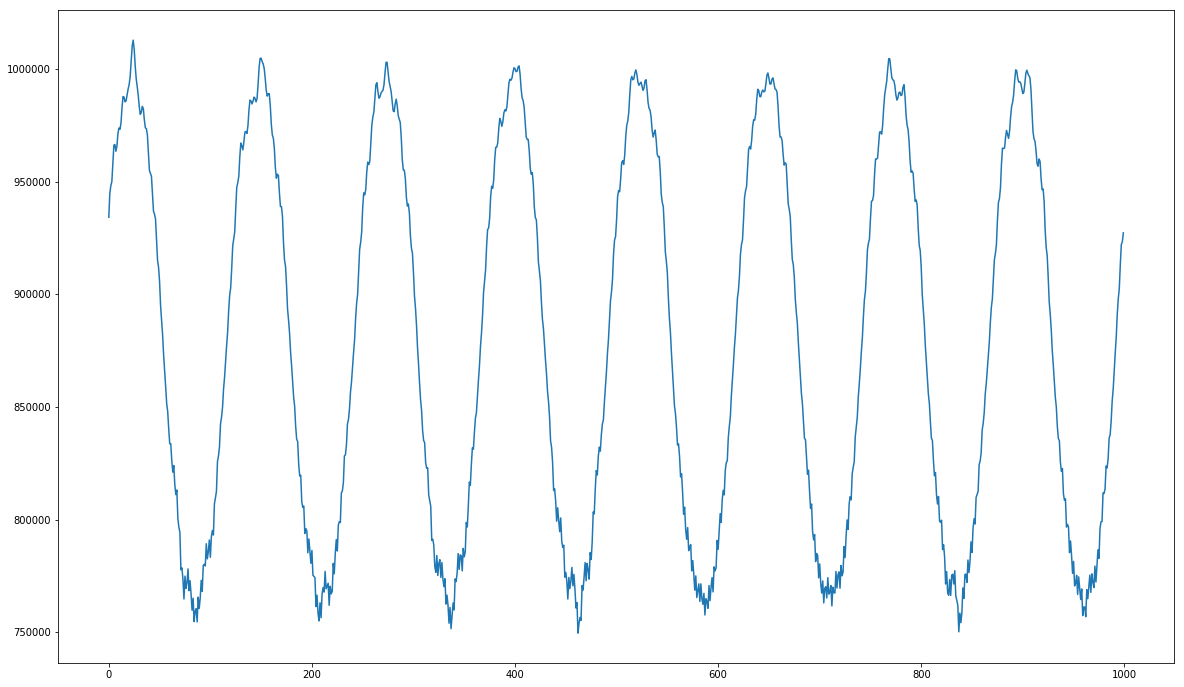

In [37]:
plt.plot(frame_audio['audio_right'][40000:41000])

In [38]:
processphillipscode(frame['demod'], linelist2)

CAV frame # 53430
CAV frame # 53430


{'codes': [(16, [8, 11, 10, 0, 0, 0]),
  (17, [15, 13, 3, 4, 3, 0]),
  (18, [15, 13, 3, 4, 3, 0]),
  (279, [8, 11, 10, 0, 0, 0]),
  (280, [8, 12, 7, 13, 13, 13]),
  (281, [8, 12, 7, 13, 13, 13])],
 'frame': 53430}

(425376,)
uint8 (504, 844) (504, 844)


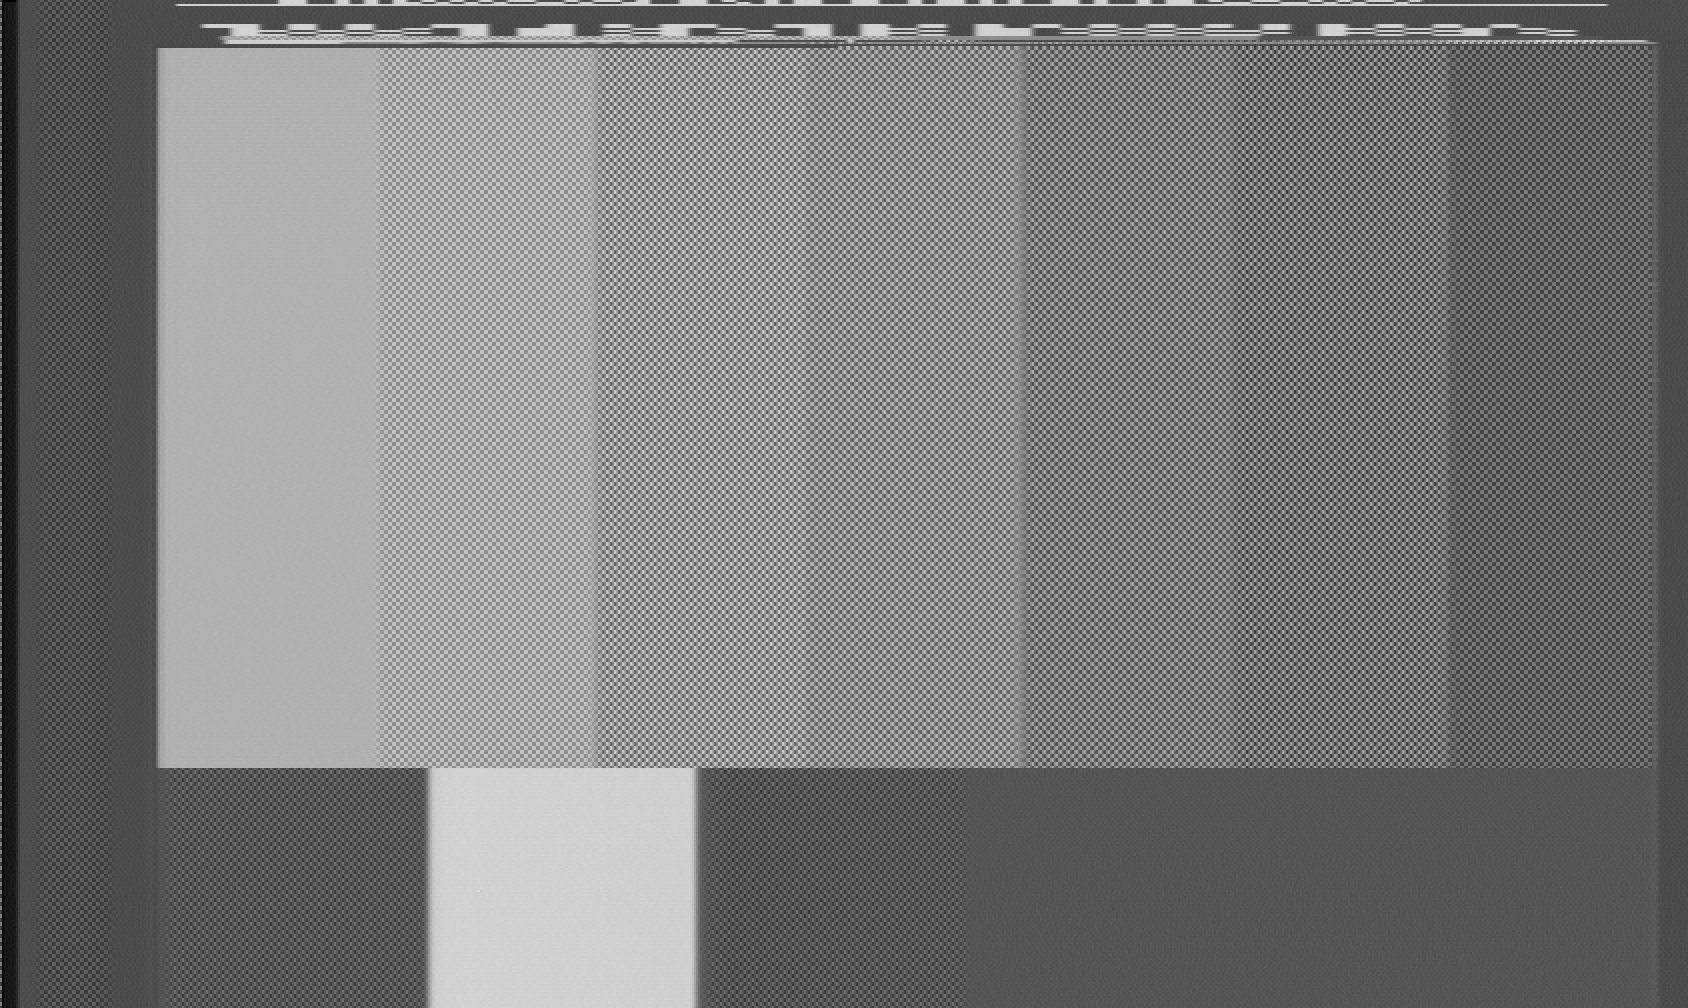

In [39]:
drawdata(output_cropped, 844, 504, hscale=2, vscale=2)

In [429]:
def audio_fdslice(SP, freqdomain):
    return np.concatenate([freqdomain[SP['audio_fdslice_lo']], freqdomain[SP['audio_fdslice_hi']]])

In [428]:

arf_div = 32 # this is good for 40mhz - 16 should be fine for 28
afft_halfwidth = (blocklen / arf_div) / 2
arf_freq = SP['freq_hz'] / (arf_div / 2)

SP = filterset.copy()

SP['audio_cfreq'] = (filterset['audio_rfreq'] + filterset['audio_lfreq']) // 2
afft_center = int((SP['audio_cfreq'] / filterset['freq_hz']) * (blocklen))

# beginning and end symmetrical frequency domain slices.  combine to make a cut-down sampling
afft_start = int(afft_center-afft_halfwidth)
afft_end = int(afft_center+afft_halfwidth)

print(afft_start, afft_end)

SP['audio_fdslice_lo'] = slice(afft_start, afft_end)
SP['audio_fdslice_hi'] = slice(blocklen-afft_end, blocklen-afft_start)

print(SP['audio_fdslice_lo'], SP['audio_fdslice_hi'])


audio_lfreq = SP['audio_lfreq']
audio_rfreq = SP['audio_rfreq']
apass = 150000
freq_hz_half = SP['freq_hz'] // 2

#afilt_len = 480 # mininum acceptable 75khz lowpass
afilt_len = 800 # good for 150khz apass
#afilt_len = 640 # good for 125khz apass

afilt_left = filtfft([sps.firwin(afilt_len, [(audio_lfreq-apass)/freq_hz_half, (audio_lfreq+apass)/freq_hz_half], pass_zero=False), 1.0])
SP['audio_lfilt'] = audio_fdslice(SP, afilt_left * SP['Fhilbert']) 
afilt_right = filtfft([sps.firwin(afilt_len, [(audio_rfreq-apass)/freq_hz_half, (audio_rfreq+apass)/freq_hz_half], pass_zero=False), 1.0])
SP['audio_rfilt'] = audio_fdslice(SP, afilt_right * SP['Fhilbert'])

plt.plot(dbify(audio_fdslice(SP, afilt_left)))
plt.plot(dbify(audio_fdslice(SP, afilt_right)))


1582 2606
slice(1582, 2606, None) slice(30162, 31186, None)


In [598]:
firstloc = 1024 * 1024 * 68000 # frame 53430
firstloc = 1024 * 1024 * 6800 # frame 5347
indata = loaddata(infile, firstloc)

indata_fft = np.fft.fft(indata)

In [599]:
hilbert = np.fft.ifft(audio_fdslice(SP, indata_fft) * SP['audio_lfilt'])
audio_left = hilberttohz(hilbert, arf_freq)

hilbert = np.fft.ifft(audio_fdslice(SP, indata_fft) * SP['audio_rfilt'])
audio_right = hilberttohz(hilbert, arf_freq)

<-3db crossing at  2441.40625
<-10db crossing at  7324.21875


/home/cpage/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


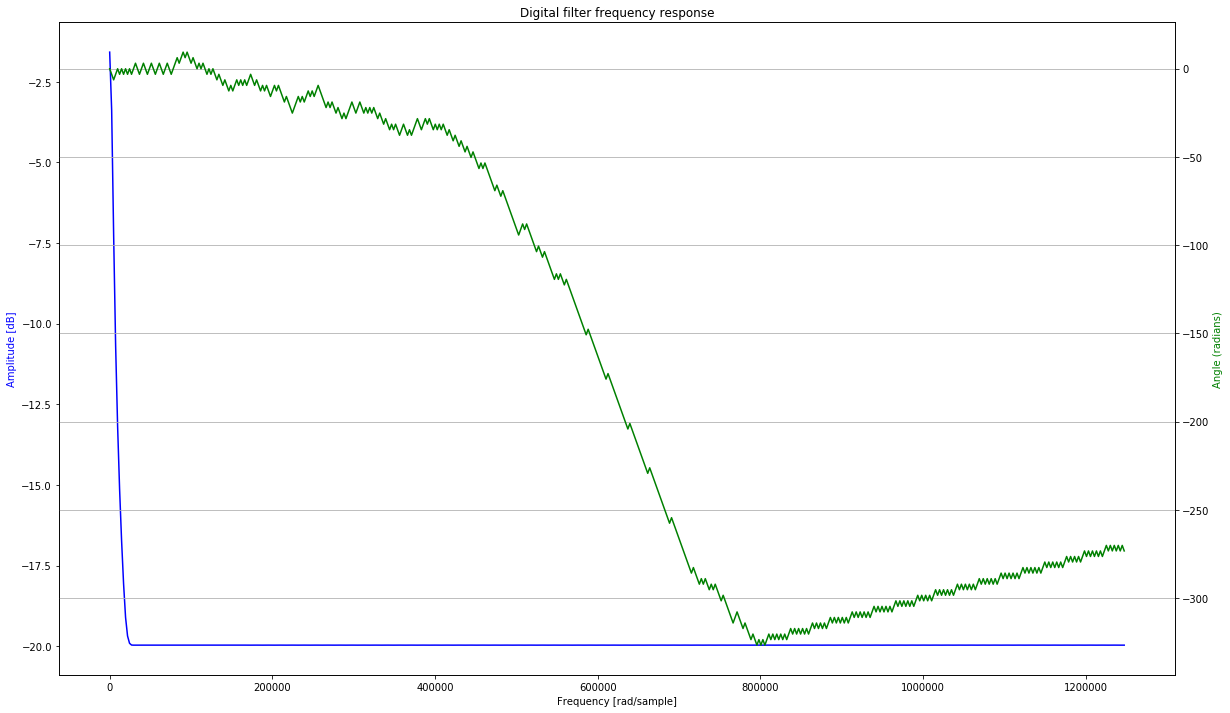

In [606]:
# fm deemphasis (75us)
# NOTE: assuming this is in khz!
table = [[.000, 0], [.1, -.01], [.5, -.23], [1, -.87], [2, -2.76], [3, -4.77], [4, -6.58], [5, -8.16], [6, -9.54], [7, -10.75], [8, -11.82], [9, -12.78], [10, -13.66], [11, -14.45], [12, -15.18], [13, -15.86], [14, -16.49], [15, -17.07], [16, -17.62], [17, -18.14], [18, -18.63], [19, -19.09], [20, -19.53], [24, -20]]

Fr = np.empty([len(table) + 1])
Am = np.empty([len(table) + 1])
for i in range(0, len(table)):
    Fr[i] = (table[i][0] * 1000) / (arf_freq / 2)
    Am[i] = (np.exp(table[i][1] / 8.7))
    
Fr[-1] = 1.0
Am[-1] = Am[-2]

Bfmdeemp = sps.firwin2(1025, Fr, Am)
doplot(Bfmdeemp, [1.0], freq=arf_freq)

-42964.2206668 84126.0081699 127090.228837
-259.761397589 142.427022266 402.188419855
63.4241192051


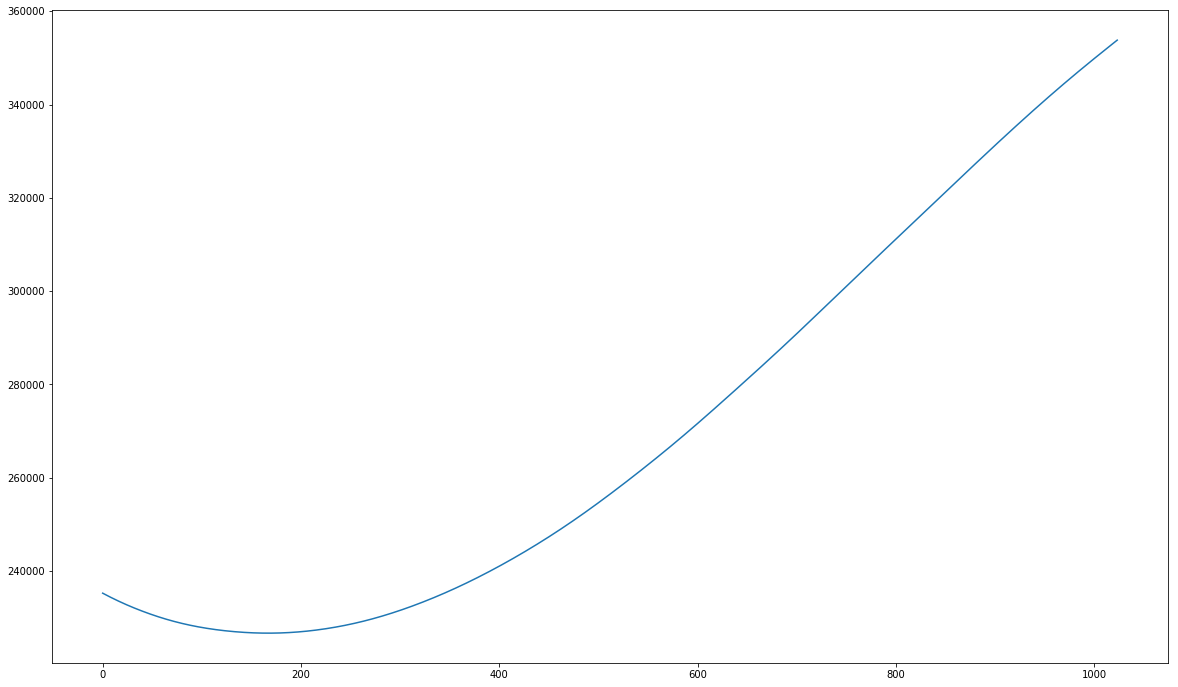

In [608]:
alpf = filtfft([sps.firwin(512, [24000/(arf_freq/2)]), [1.0]], len(demod_fft))
adeemp = filtfft([Bfmdeemp, [1.0]], len(demod_fft))

cut = 1024

demod_fft = np.fft.fft(audio_left)
decode_left = np.abs(np.fft.ifft(demod_fft * alpf * adeemp))[cut:]

demod_fft = np.fft.fft(audio_right)
decode_right = np.abs(np.fft.ifft(demod_fft * alpf * adeemp))[cut:]

m = np.mean(decode_left)
print(np.min(decode_left) - m, np.max(decode_left) - m, np.max(decode_left) - np.min(decode_left))

m = np.mean(decode_right)
print(np.min(decode_right) - m, np.max(decode_right) - m, np.max(decode_right) - np.min(decode_right))
#print(20*np.log10(200000 / np.std(decode_right)))
print(20*np.log10((np.max(decode_left) - np.min(decode_left)) / np.std(decode_right)))
#plt.plot(decode_left[256:]+100000)
#plt.plot(decode_right[256:])

plt.plot(decode_left[:])

In [585]:
25000/137000

0.18248175182481752

In [586]:
20*np.log10(25000/137000)

-14.775611169687384

In [603]:
fright = np.fft.fft(decode_right[256:])[1:]

In [604]:
np.argmax(fright[0:512])

0

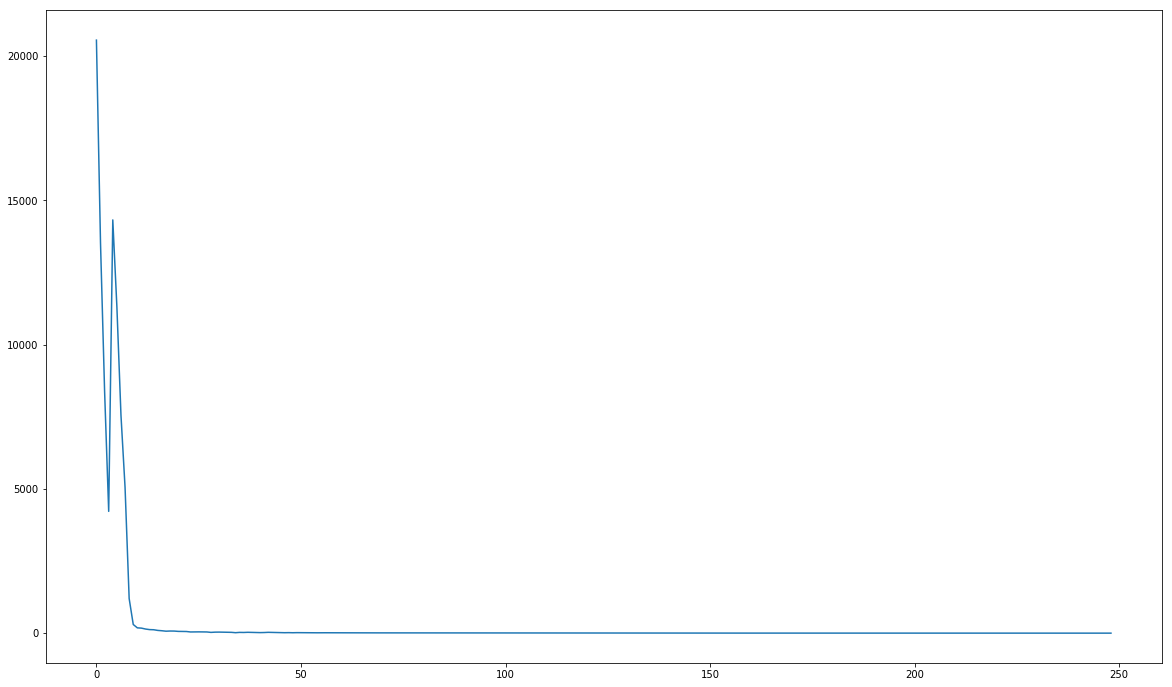

In [605]:
plt.plot(np.abs(np.fft.fft(decode_right[256:]))[1:250])

In [472]:
len(decode_right[256:])

1792

In [457]:
arf_freq

2500000.0

In [476]:
(19/1792)*arf_freq

26506.69642857143

In [ ]:
np.argmax()

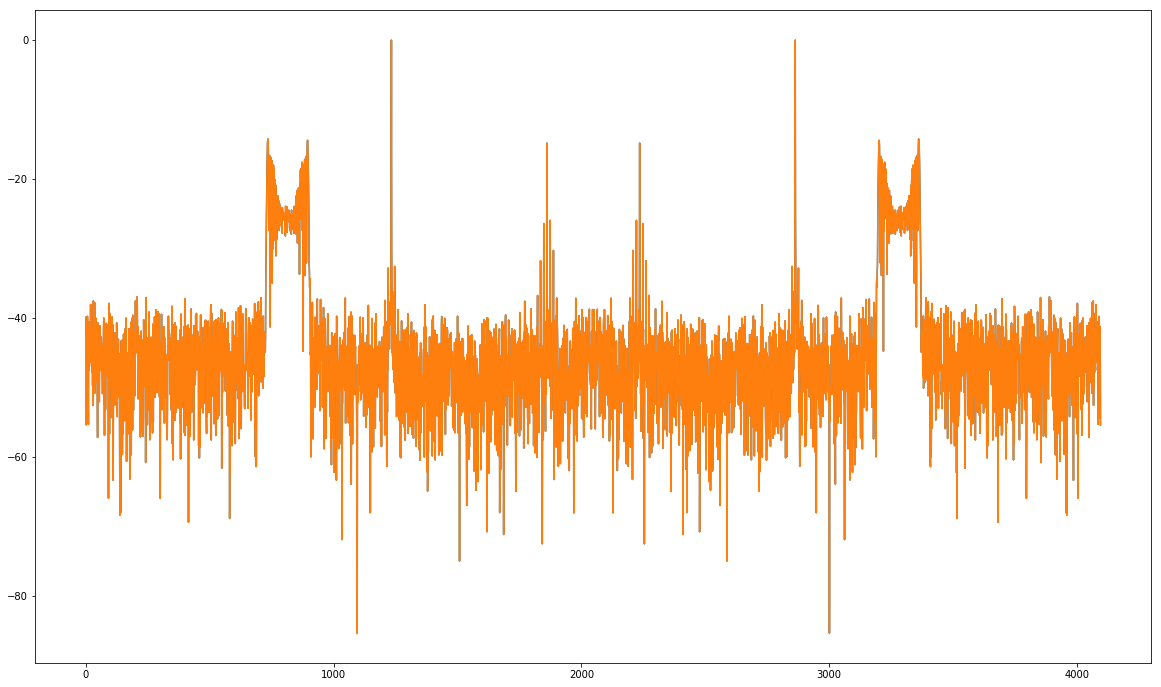

In [172]:
plt.plot(dbify(audio_fdslice(SP, indata_fft)))
plt.plot(dbify(audio_fdslice(SP, indata_fft)))

In [37]:
SP = filterset.copy()

# compute audio center frequency - useful for the narrow BPF
SP['audio_cfreq'] = (filterset['audio_rfreq'] + filterset['audio_lfreq']) // 2
acenter = int((SP['audio_cfreq'] / filterset['freq_hz']) * (blocklen))

audio_lfreq = SP['audio_lfreq']
audio_rfreq = SP['audio_rfreq']
apass = 80000

# -/+ from center (for now)
afft_halfwidth = 512

# found that FIR filters do a better job here... rather long ones at 40mhz. 
# TODO: pre-chop?
freq_hz_half = SP['freq_hz'] / 2
SP['audio_filtleft'] = [sps.firwin(192, [(audio_lfreq-apass)/freq_hz_half, (audio_lfreq+apass)/freq_hz_half], pass_zero=False), [1.0]]
SP['audio_filtright'] = [sps.firwin(192, [(audio_rfreq-apass)/freq_hz_half, (audio_rfreq+apass)/freq_hz_half], pass_zero=False), [1.0]]

In [65]:
abpf_width = 512
# output frequency when scaled down
abpf_hz_half = ((abpf_width * 2) / blocklen) * SP['freq_hz']
SP['abpf_hz_half'] = abpf_hz_half

abpf_lowfreq = SP['audio_cfreq'] - (abpf_hz_half / 2)
abpf_highfreq = SP['audio_cfreq'] + (abpf_hz_half / 2)

SP['audio_filtleft'] = [sps.firwin(256, [(audio_lfreq-apass-abpf_lowfreq)/abpf_hz_half, (audio_lfreq+apass-abpf_lowfreq)/abpf_hz_half], pass_zero=False), [1.0]]
SP['audio_filtright'] = [sps.firwin(256, [(audio_rfreq-apass-abpf_lowfreq)/abpf_hz_half, (audio_rfreq+apass-abpf_lowfreq)/abpf_hz_half], pass_zero=False), [1.0]]

In [73]:
acenter = (filterset['audio_rfreq'] + filterset['audio_lfreq']) // 2
acenter = int((acenter / filterset['freq_hz']) * (blocklen))

In [74]:
ffirstloc = 1024 * 1024 * 68000 # frame 53430
firstloc = 1024 * 1024 * 6800 # frame 5347
indata = loaddata(infile, firstloc)

indata_fft = np.fft.fft(indata)

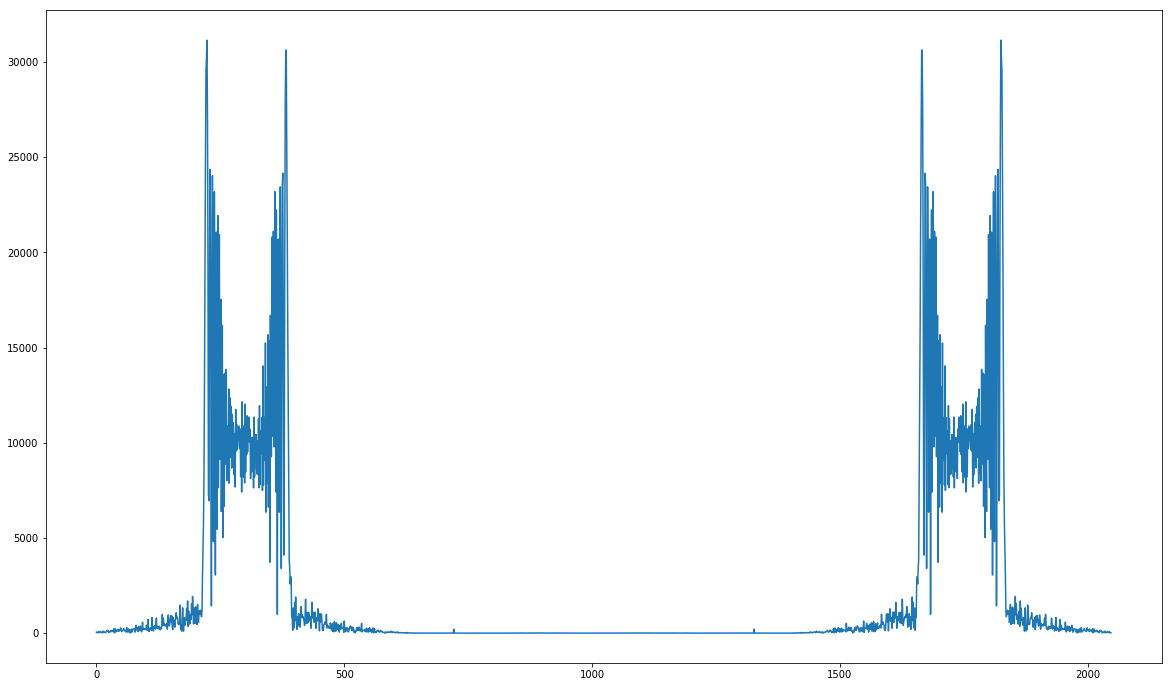

In [78]:
freq_hz_half = 20000000
audio_lfreq = filterset['audio_lfreq']
audio_rfreq = filterset['audio_rfreq']
apass = 50000

lch = sps.firwin(192, [(audio_lfreq-apass)/freq_hz_half, (audio_lfreq+apass)/freq_hz_half], pass_zero=False)
rch = sps.firwin(192, [(audio_rfreq-apass)/freq_hz_half, (audio_rfreq+apass)/freq_hz_half], pass_zero=False)

indata_fft_lch = filtfft([lch, [1.0]], blocklen) * indata_fft
indata_fft_rch = filtfft([rch, [1.0]], blocklen) * indata_fft

acenter = (filterset['audio_rfreq'] + filterset['audio_lfreq']) // 2
acenter = int((acenter / filterset['freq_hz']) * (blocklen))

aslice1 = slice(acenter-afft_halfwidth, acenter+afft_halfwidth)
aslice2 = slice(blocklen-(acenter+afft_halfwidth), blocklen-(acenter-afft_halfwidth))

x = np.concatenate([indata_fft_lch[aslice1], indata_fft_lch[aslice2]])
plt.plot(np.abs(x))


-119237.916853 81857.206927 201095.12378


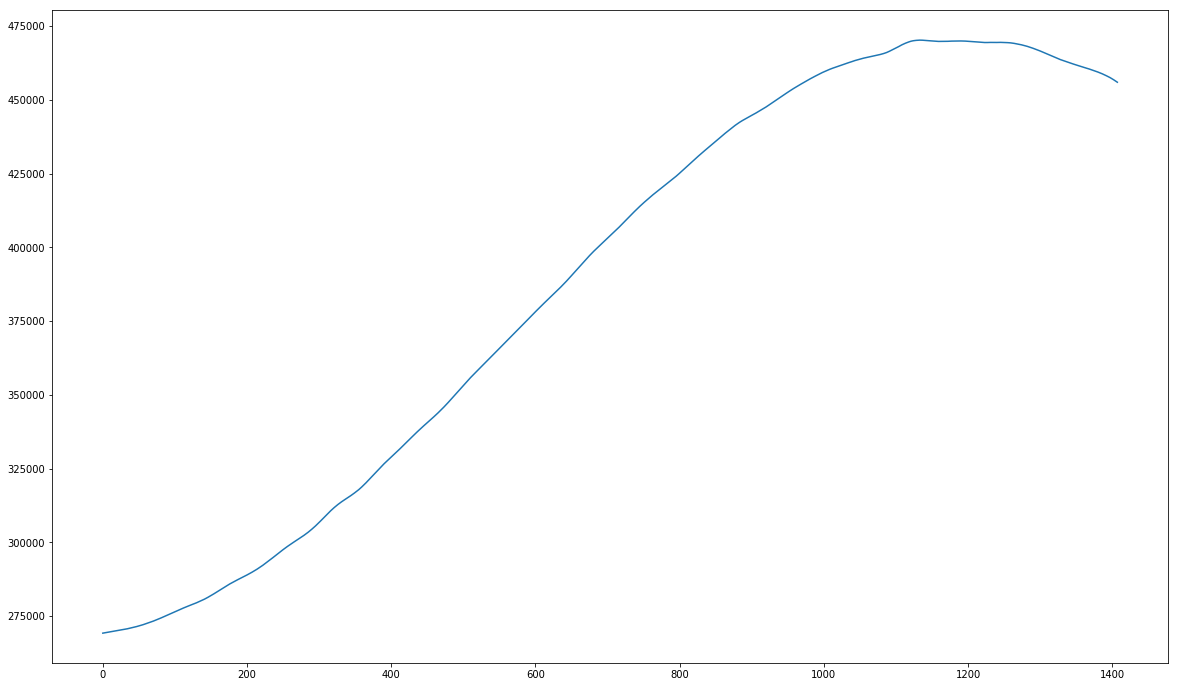

In [76]:
newfreq = filterset['freq_hz'] * ((len(x))/blocklen)

Fshorthilbert = np.fft.fft(hilbert_filter, len(x))

hilbert = np.fft.ifft(x * Fshorthilbert)
#hilbert_cut = np.concatenate([hilbert[aslice1], hilbert[aslice2]])
data = hilberttohz(hilbert, newfreq)

demod_fft = np.fft.fft(data)

#alpf = filtfft(sps.butter(1, [.02/(newfreq/2/1000000)], btype='lowpass'), len(demod_fft))
alpf = filtfft([sps.firwin(128, [.025/(newfreq/2/1000000)]), 1.0], len(demod_fft))
decode = np.abs(np.fft.ifft(demod_fft * alpf))[640:]
m = np.mean(decode)
print(np.min(decode) - m, np.max(decode) - m, np.max(decode) - np.min(decode))
plt.plot(decode)

In [53]:
203128*.857

174080.696

In [281]:
(blocklen/8)-len(decode)

550.0

In [284]:
5120/8

640.0

In [282]:
blocklen/8

4096.0

In [280]:
len(decode)/(blocklen/8)

0.86572265625

In [60]:
afft = np.abs(np.fft.fft(audio))
afft = db = 20 * np.log10(abs(afft))
afft -= np.max(afft)
plt.plot(afft[1:100])

NameError: name 'audio' is not defined

## 40000000*(360/237144)

In [50]:
(15000/20000000)*1000

0.75

In [51]:
linelist2[6]

46338.818077911215

In [151]:
outfile = open('tmp.tbc', 'wb')
outfile.write(output_cropped)

852440

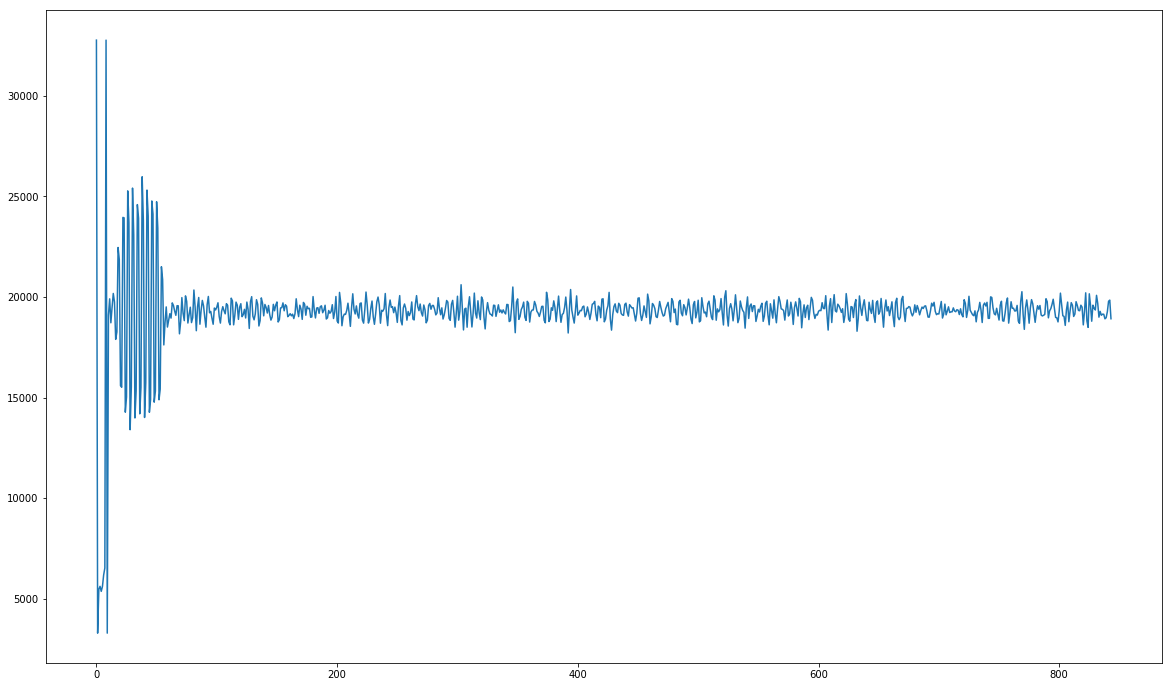

In [155]:
l = 3
plt.plot(output_cropped[l*844:(l + 1) * 844])

>-3db crossing at  5.4296875
>3db crossing at  9.765625


/home/cpage/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


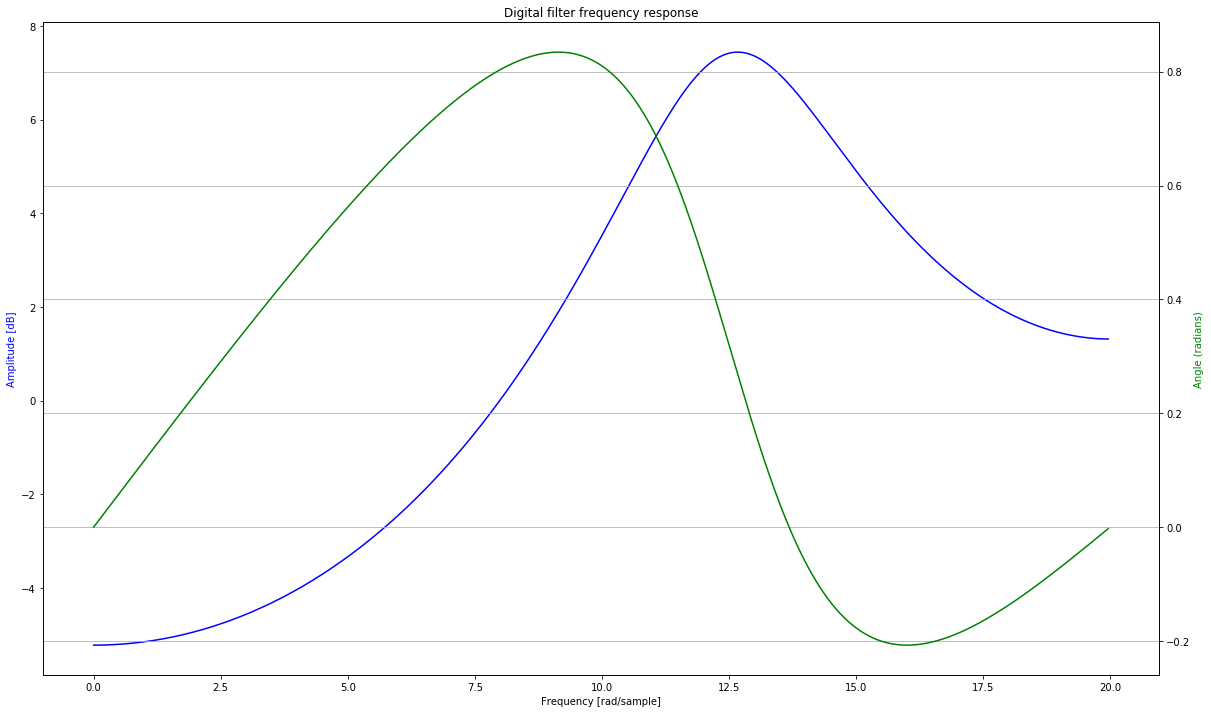

In [415]:
videomtf = sps.zpk2tf([], [polar2z(.7,np.pi*12.5/20), polar2z(.7,np.pi*27.5/20)], 1.11)
doplot(*videomtf)

/home/cpage/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/home/cpage/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/cpage/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


<-3db crossing at  7.9296875
<-10db crossing at  10.5078125
>-10db crossing at  14.53125
>-3db crossing at  17.109375


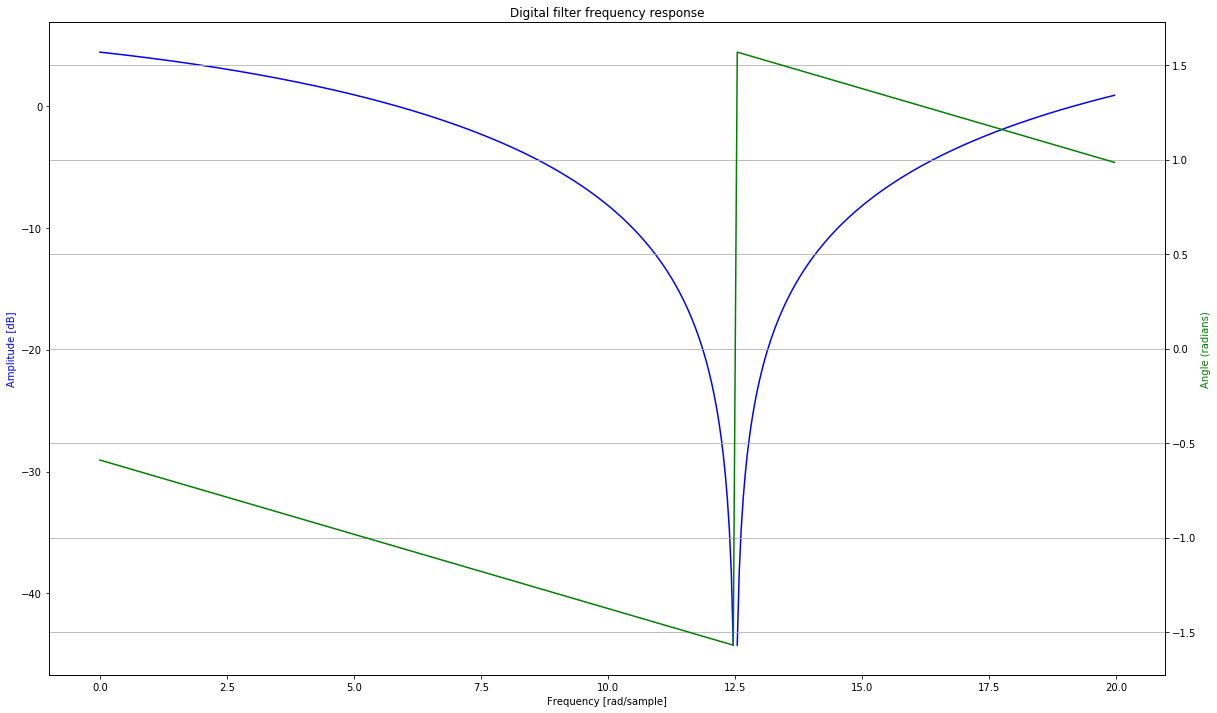

In [419]:
videomtf = sps.zpk2tf([polar2z(1,np.pi*12.5/20)], [], 1.0)
doplot(*videomtf)

In [411]:
videomtf

(array([ 1.11]),
 array([ 1.00000000 +0.00000000e+00j,  0.53575681 +1.11022302e-16j,
         0.49000000 +1.38777878e-16j]))